<h1>ECON 140R Class 17</h1>

<b>Spurious correlation</b> is a big problem in time series econometrics. It describes a situation where two variables appear to be correlated for completely accidental reasons, and our statistical methods may not allow us to correct the picture easily. Let us explore a hilariously weird example in time series data provided by [Tyler Vigen on his website](https://tylervigen.com/spurious-correlations). Along the way, we will examine some time series commands in __R__.

Learning objectives:

1. Time series regressions can be `lm()` regressions
2. In __R__, you can also use the `dynlm` package and `dynlm()` after a data transform with `ts()`
3. Spurious correlation is hilarious and potentially pernicious and persistent

Below we load in `haven` like usual, and we also load in `dynlm` to run time-series models.

In [27]:
library(haven)
install.packages("dynlm")
library(dynlm)

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)



<h2>A preposterious relationship ...</h2>

The data in `spurious.dta` are hilariously weird. Inspired by Tyler Vigen's example, I found two time series from separate sources: the divorce rate per 1,000 in the state of Maine, `divorceme`, from CDC vital statistics; and the national per capita consumption of margarine in pounds per person (per year). Both series are annual.

In [28]:
spurious <- read_dta("spurious.dta")
spurious

year,divorceme,margarine
<dbl>,<dbl>,<dbl>
1999,5.1,8.0
2000,5.0,8.3
2001,4.7,7.1
2002,4.6,6.6
2003,4.4,5.3
2004,4.3,5.3
2005,4.1,4.1
2006,4.2,4.6
2007,4.2,4.6


The __R__ package `dynlm` contains some special tools for dealing with time series, and `ts()` is one of them. The convention appears to be that we should exclude the time variable itself, in this case `year`, if we want to run things easily like `plot` with the dataset.

Florian Heiss writes a little about this package in [Section 10.3](http://www.urfie.net/read/index.html#page/201), which mirrors the latest edition of Wooldridge, if you have access to that. Heiss does not go into great detail, but you can still get big-picture takeaways.

In [29]:
# Let's omit the year column by looking at columns 2:3
# The start field is the beginning year, and frequency = 1 means annual data.
spurious_ts <- ts(spurious[c(2:3)], start = 1999, frequency = 1)
head(spurious_ts)

divorceme,margarine
5.1,8.0
5.0,8.3
4.7,7.1
4.6,6.6
4.4,5.3
4.3,5.3


It's never a bad idea to look at a scatter plot of a $y$ versus an $x$. The choice of either one is ... totally silly in this context, but for kicks, let us imagine that the divorce rate in Maine ($y$) is caused by the per capita consumption of margarine ($x$).

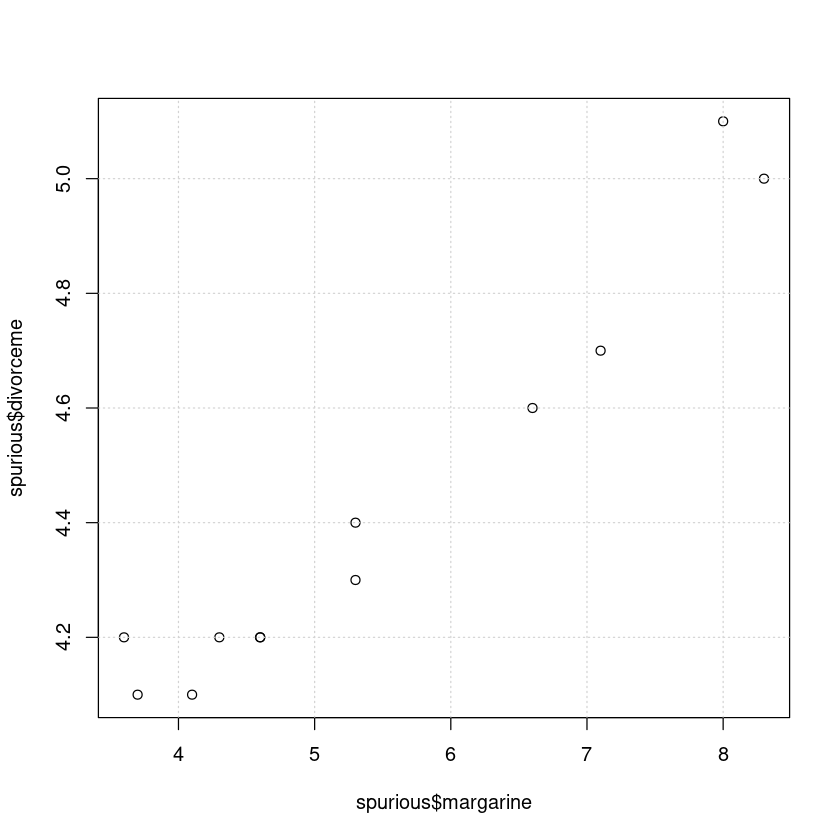

In [30]:
plot(spurious$margarine, spurious$divorceme)
grid()

It is also common to look at time series along a plot with time as the $x$-variable, and the time series as two (or more) different series graphed against time.

Here is a nifty trick to overlay two time series on a time plot using the built-in `plot()` command, using a call to `lines()` afterward:

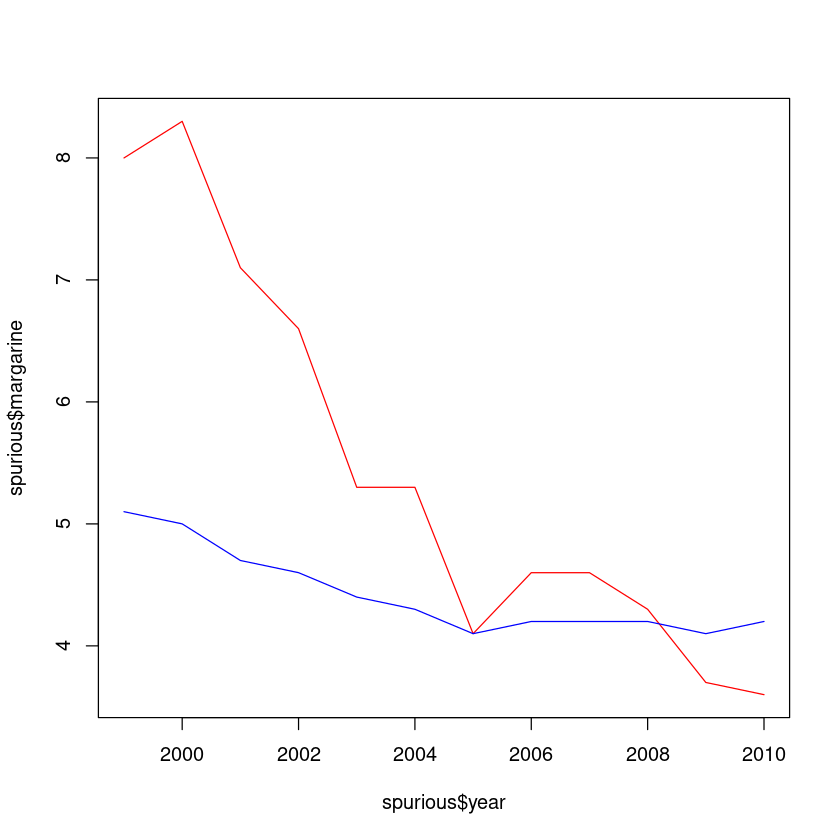

In [31]:
plot(spurious$year, spurious$margarine, type = "l", col = "red")
lines(spurious$year, spurious$divorceme, col = "blue")

This picture is not quite as evocative as Tyler Vigen's, because Tyler introduced a secondary $y$-axis with its own scaling. This is visible if you look closely at the left and right sides of the original graph, reprinted for kicks below:

<img src="images/divorce_margarine.png" width="700" />

Part of the `dynlm` package appears to organize variables so that calls to `plot()` produce reasonable pictures. If you want to lose your mind, try replacing "spurious_ts" with "spurious" below!

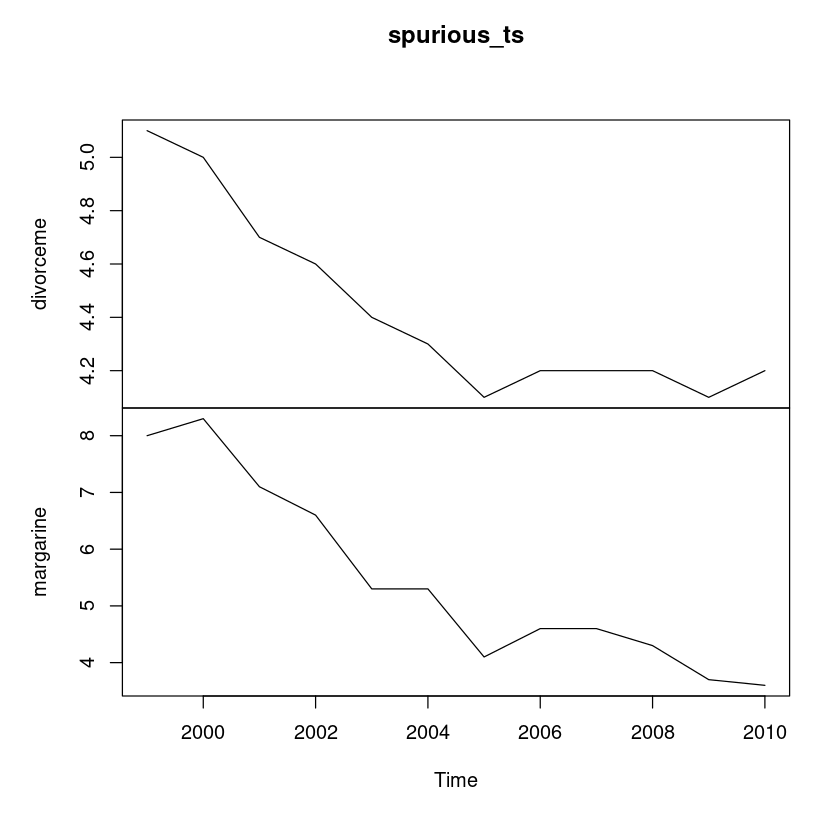

In [32]:
plot(spurious_ts)

<h2>... can still be statistically significant</h2>
    
Ready for some hilarious high jinks?

There is nothing stopping us from running `lm()` to estimate the scatter plot relationship that we saw earlier, pretending in our heads that it is not preposterous to argue that national margarine consumption causes the divorce rate in Maine. (It is also preposterous to propose the reverse; I just chose one and went with it.)

Below, we run this regression using `lm()`:

$$ 
divorceme_t = \alpha + \beta \ margarine_t + \epsilon_t
$$

where now the observations are across $t$ for time, rather than units like people or households. Bombs away!

In [33]:
spurious_reg1 <- lm(divorceme ~ margarine, data = spurious)
summary(spurious_reg1)


Call:
lm(formula = divorceme ~ margarine, data = spurious)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09256 -0.05159 -0.02694  0.01802  0.15569 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.30683    0.08855   37.35 4.51e-12 ***
margarine    0.20486    0.01559   13.14 1.24e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08507 on 10 degrees of freedom
Multiple R-squared:  0.9453,	Adjusted R-squared:  0.9398 
F-statistic: 172.8 on 1 and 10 DF,  p-value: 1.236e-07


This is all preposterous. What the model purports to say is that for every additional pound of annual margarine consumption, there is an increase in the divorce rate per 1,000 of $\beta = 0.2$. The constant term $\alpha$ tells us what the divorce rate is predicted to be if margarine consumption is zero.

Often, a good solution is to introduce a <b>time trend</b> into the regression. The idea is that when $y$ and $x$ are both trending, modeling a time trend might allow ordinary least squares to let the time trend "win out" in a horse race for explaining $y$, removing the spurious correlation. The math would become something like this:

$$ 
divorceme_t = \alpha + \beta \ margarine_t + \delta \ t + \epsilon_t
$$

where the time trend is $\delta$ and $t$ indexes the time periods. For us, $t$ indexes years.

Unfortunately for us, in this case a time trend does not seem to help at all. Here is how you could code it with `lm()`:

In [34]:
spurious_reg2 <- lm(divorceme ~ margarine + year, data = spurious)
summary(spurious_reg2)


Call:
lm(formula = divorceme ~ margarine + year, data = spurious)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07183 -0.05594 -0.02838  0.02318  0.16099 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -47.28692   40.95859  -1.155 0.278026    
margarine     0.25655    0.04452   5.763 0.000272 ***
year          0.02510    0.02032   1.235 0.248013    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08292 on 9 degrees of freedom
Multiple R-squared:  0.9532,	Adjusted R-squared:  0.9428 
F-statistic: 91.68 on 2 and 9 DF,  p-value: 1.036e-06


Note how the intercept is very different now. This is because we have tossed in the variable `year`, which ranges between 1999 and 2010. The reason the intercept is so large and negative is because we only get just the constant term for the out-of-sample prediction for the year 0. 

(Even worse, apparently there was no year 0. That is why the new millennium apparently began on January 1, 2001. Drat these infernal calendars.)

<h2>dynlm( ) looks like lm( )</h2>

There is another way to code a time trend using the time series functionality of `dynlm`, with a call to `trend()`:

In [35]:
spurious_reg3 <- dynlm(divorceme ~ margarine + trend(spurious_ts), data = spurious_ts)
summary(spurious_reg3)


Time series regression with "ts" data:
Start = 1999, End = 2010

Call:
dynlm(formula = divorceme ~ margarine + trend(spurious_ts), data = spurious_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07183 -0.05594 -0.02838  0.02318  0.16099 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.86153    0.37068   7.720 2.94e-05 ***
margarine           0.25655    0.04452   5.763 0.000272 ***
trend(spurious_ts)  0.02510    0.02032   1.235 0.248013    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08292 on 9 degrees of freedom
Multiple R-squared:  0.9532,	Adjusted R-squared:  0.9428 
F-statistic: 91.68 on 2 and 9 DF,  p-value: 1.036e-06


What appears to have happened here is that the beginning year is reset to be $t = 1$. As a check, we can examine how the previous results compare to what we see here:

In [36]:
# using lm()
-47.28692 + 1999*0.02510
# using dynlm()
2.86153 + 0.02510

[1] 2.88798

[1] 2.88663

Hm. Well, close enough I suppose!

Some other things we can quickly and easily explore using `dynlm()` are whether looking at first differences might help. Consider again the model in levels, with a time trend:

$$ 
divorceme_t = \alpha + \beta \ margarine_t + \delta \ t + \epsilon_t
$$

If this is true, then lagging the equation by one period should produce:

$$ 
divorceme_{t-1} = \alpha + \beta \ margarine_{t-1} + \delta \ (t - 1) + \epsilon_{t-1}
$$

and then we might subtract the second equation from the first, and use the $\Delta$ operator to denote the time difference. Several terms cancel, and we end up with:

$$ 
\Delta divorceme_t = \delta + \beta \ \Delta margarine_t + \nu_t
$$

where $\nu_t \equiv \epsilon_t - \epsilon_{t-1}$. It is not clear whether we have gained anything by doing this, but it is probably worth examining. With `dynlm()`, we can quickly run this model using the `d()` function:

In [37]:
spurious_reg4 <- dynlm(d(divorceme) ~ d(margarine), data = spurious_ts)
summary(spurious_reg4)


Time series regression with "ts" data:
Start = 2000, End = 2010

Call:
dynlm(formula = d(divorceme) ~ d(margarine), data = spurious_ts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13062 -0.04228  0.01394  0.03182  0.13363 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.01757    0.02890  -0.608  0.55821   
d(margarine)  0.16062    0.04043   3.973  0.00324 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07943 on 9 degrees of freedom
Multiple R-squared:  0.6369,	Adjusted R-squared:  0.5965 
F-statistic: 15.79 on 1 and 9 DF,  p-value: 0.003239


But again, this doesn't help remove the hilariously persistent spurious correlation! May you melt a million deaths, national margarine consumption!!

<h2>Serial correlation</h2>

Another problem is that there is <b>serial correlation</b> in the error term. Serial correlation occurs when consecutive error terms, like $\epsilon_t$ and $\epsilon_{t+1}$, are systematically related to one another. Although we did not discuss it much or at all, in a well designed study like a randomized controlled trial, the error terms are well behaved, meaning they are independent and identically distributed. When they are serially correlated, they are not.

In all of our models here, we can see the (positive) serial correlation. It shows up as consecutive errors that are above or below the time axis.

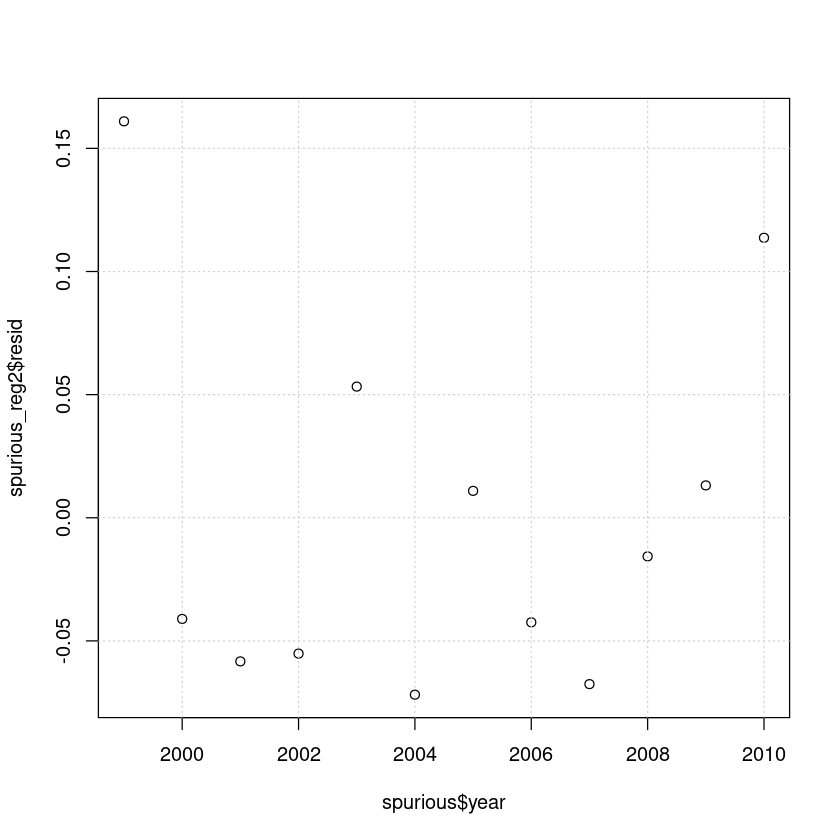

In [38]:
plot(spurious$year, spurious_reg2$resid)
grid()

And here is the serial correlation in our model 4, with differenced $x$ and $y$ variables. Jiminy Christmas!

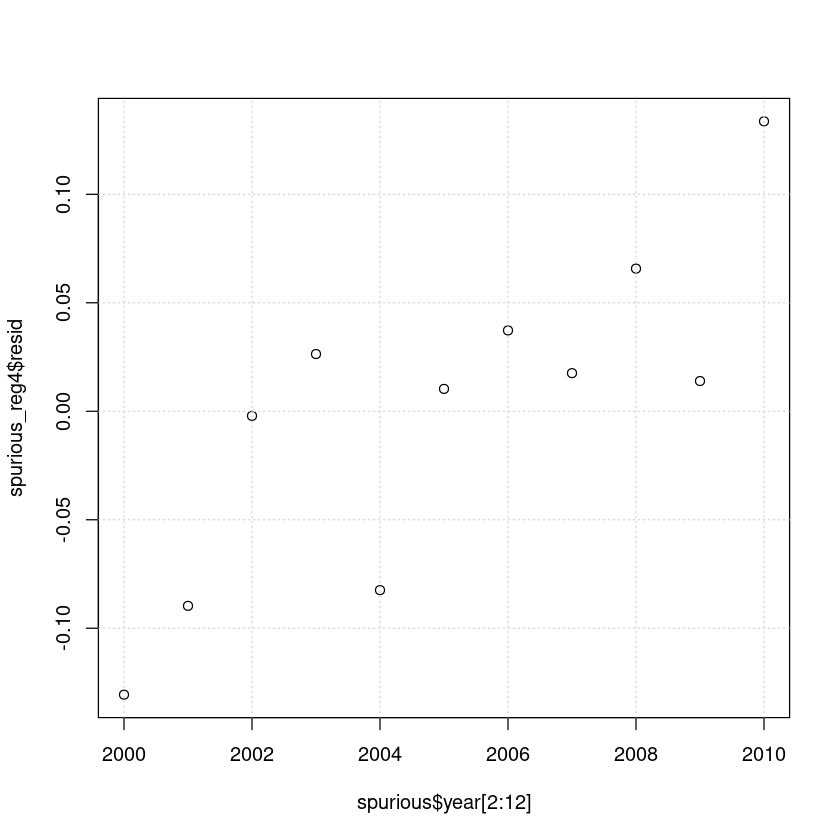

In [39]:
plot(spurious$year[2:12], spurious_reg4$resid)
grid()

Does this all seem hopeless? We certainly seem trapped in a prison made out of margarine, with buttery fetters. But some takeaways are as follows:

1. Be skeptical of time-series regressions
2. Examine first differences and/or percentage changes. This is also no silver bullet
3. Plot residuals
4. If we knew about a <i>change</i> in something, driven by policy or weather, that might be useful to examine 

<div style="text-align: right"> <span style="font-family:Papyrus; ">And they lived happily ever after. The End.</span></div>